In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import os
import glob

In [2]:
import geopandas as gpd
import rioxarray

In [3]:
gdf = gpd.read_file("SHP/chn_adm_ocha_2020_shp", layer=2)

JS = gdf[gdf['ADM1_PCODE'] == 'CN032']
HB = gdf[gdf['ADM1_PCODE'] == 'CN042']
HN = gdf[gdf['ADM1_PCODE'] == 'CN043']
ZJ = gdf[gdf['ADM1_PCODE'] == 'CN033']
JX = gdf[gdf['ADM1_PCODE'] == 'CN036']
AH = gdf[gdf['ADM1_PCODE'] == 'CN034']
SH = gdf[gdf['ADM1_PCODE'] == 'CN031']

shpli = [JS, HB, HN, ZJ, JX, AH]

basin = gpd.read_file("SHP/major_basins_of_the_world_0_0_0.zip")

yrb=basin[basin['NAME']=='Yangtze']
multi=gpd.GeoDataFrame(pd.concat(shpli, ignore_index=True))

In [4]:
models=[f.name for f in os.scandir('formatted_grid') if f.is_dir() and f.name != 'cpc.observed']

In [5]:
yrb.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [6]:
multi.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [7]:
def rectangle_clip(gdf, xrds):
    # Find the bounding box of the shapefile
    bbox = gdf.total_bounds  # [minx, miny, maxx, maxy]
    xrds.rio.set_spatial_dims('lon', 'lat')
    xrds.rio.write_crs("EPSG:4326", inplace=True)
    return xrds.rio.clip_box(minx=bbox[0], miny=bbox[1], maxx=bbox[2], maxy=bbox[3])

# Hwave Cwave mean trend plot
Plot:

| 2022 | 2050 | 2100 | tTrend |

In [8]:
hda=xr.open_dataset('waves/observed_cpc_heatwave.nc')['heatwave_frequency'][-22:-2].mean('time')
cda=xr.open_dataset('waves/observed_cpc_coldwave.nc')['coldwave_frequency'][-22:-2].mean('time')
gr=[rectangle_clip(multi, hda), rectangle_clip(multi, cda)]

In [9]:
hda

<xarray.DataArray 'heatwave_frequency' (lat: 360, lon: 720)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * lat          (lat) float32 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon          (lon) float32 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8
    spatial_ref  int32 0

In [10]:
class DeprModelData:
    def __init__(self, model, experiment):

        self.timeframe=np.unique(xr.open_dataset(f"waves/{experiment}_{model}_coldwave.nc")['time'].to_numpy())
        try:
    
            cw_arr=rectangle_clip(multi, xr.open_dataset(f"waves/{experiment}_{model}_coldwave.nc")['coldwave_frequency'])
            hw_arr=rectangle_clip(multi, xr.open_dataset(f"waves/{experiment}_{model}_heatwave.nc")['heatwave_frequency'])
               
        except:
            raise RuntimeError(f'Check datasets for model {model}!')
            
        self.cold=cw_arr
        self.heat=hw_arr

def select(DeprModelData, ssp, ex=[]):

    if len(DeprModelData.heat) == len(DeprModelData.timeframe):
        print('Time shape match. Using default strategy.')
        heat=DeprModelData.heat
        cold=DeprModelData.cold
        
    else:
        print('Aggregated SSPs. Using alt strategy.')

        try:
            if type(ex) is list:
                multip=0

                for l,s in {'ssp126':1, 
                            'ssp245':2,
                            'ssp370':3,
                            'ssp585':5}.items():
                    if not (s in ex):
                        if ssp==l:
                            heat=DeprModelData.heat[86*multip:86*(multip+1),:,:]
                            cold=DeprModelData.cold[86*multip:86*(multip+1),:,:]
                        multip+=1
                
            else: raise ValueError('Bad ex input. Ex is a list.')
                
        except:
            raise ValueError('Bad ssp dealing.')

    return (cold, heat)

In [11]:
class MultiProvData:

    def initialize_ssp(self, model, ssp, ex):
        model_data = DeprModelData(model, ssp)
        return select(model_data, ssp, ex)

    def is_ssp_available(self, ssp):
        a=ssp in [path.split('_')[3] for path in glob.glob(f'NASA-CMIP/CMIP6-SSP-Temp/{self.model}/tasmin_*.nc')]
        b=ssp in [path.split('_')[3] for path in glob.glob(f'NASA-CMIP/CMIP6-SSP-Temp/{self.model}/tasmax_*.nc')]
        return a and b
    
    def __init__(self, model):
        self.model=model

        exc=[]
        
        if self.is_ssp_available('ssp126'): 
            self.ssp126=self.initialize_ssp(model, 'ssp126', exc)
        else:
            self.ssp126=None
            exc.append(1)
        
        if self.is_ssp_available('ssp245'):
            self.ssp245=self.initialize_ssp(model, 'ssp245', exc)
        else: 
            self.ssp245=None
            exc.append(2)

        if self.is_ssp_available('ssp370'):
            self.ssp370=self.initialize_ssp(model, 'ssp370', exc)
        else:
            self.ssp370=None
            exc.append(3)

        if self.is_ssp_available('ssp585'):
            self.ssp585=self.initialize_ssp(model, 'ssp585', exc)
        
        else:
            self.ssp585=None
        
        print(f'Prepared for {model}.')

In [12]:
len(DeprModelData('TaiESM1', 'ssp126').timeframe)

86

In [17]:
import netCDF4 as nc

In [18]:
"""
for i in range(2015, 2100):
    print(i)
    try:
        nc.Dataset(f'NASA-CMIP/CMIP6-SSP-Temp/MRI-ESM2-0/tasmax_day_MRI-ESM2-0_ssp585_r1i1p1f1_gn_{i}.nc').variables['tasmax'][:]
    except:
        print('tasmax problem.')
        pass
    try:
        nc.Dataset(f'NASA-CMIP/CMIP6-SSP-Temp/MRI-ESM2-0/tasmin_day_MRI-ESM2-0_ssp585_r1i1p1f1_gn_{i}.nc').variables['tasmin'][:]
    except:
        print('tasmin problem.')
        pass
"""

"\nfor i in range(2015, 2100):\n    print(i)\n    try:\n        nc.Dataset(f'NASA-CMIP/CMIP6-SSP-Temp/MRI-ESM2-0/tasmax_day_MRI-ESM2-0_ssp585_r1i1p1f1_gn_{i}.nc').variables['tasmax'][:]\n    except:\n        print('tasmax problem.')\n        pass\n    try:\n        nc.Dataset(f'NASA-CMIP/CMIP6-SSP-Temp/MRI-ESM2-0/tasmin_day_MRI-ESM2-0_ssp585_r1i1p1f1_gn_{i}.nc').variables['tasmin'][:]\n    except:\n        print('tasmin problem.')\n        pass\n"

# Now, Future, Trend

In [14]:
import gc

In [15]:
models

['ACCESS-ESM1-5',
 'CNRM-CM6-1',
 'BCC-CSM2-MR',
 'ACCESS-CM2',
 'CanESM5',
 'MIROC-ES2L',
 'CNRM-ESM2-1',
 'EC-Earth3',
 'KIOST-ESM',
 'MIROC6',
 'KACE-1-0-G',
 'FGOALS-g3',
 'GISS-E2-1-G',
 'MRI-ESM2-0',
 'HadGEM3-GC31-LL',
 'INM-CM4-8',
 'INM-CM5-0',
 'IPSL-CM6A-LR',
 'NESM3',
 'CMCC-CM2-SR5',
 'GFDL-CM4',
 'CMCC-ESM2',
 'HadGEM3-GC31-MM',
 'NorESM2-LM',
 'UKESM1-0-LL']

In [16]:
a=MultiProvData(models[0])
csum=[a.ssp126[0],a.ssp245[0],a.ssp370[0],a.ssp585[0]]
hsum=[a.ssp126[1],a.ssp245[1],a.ssp370[1],a.ssp585[1]]

del a
gc.collect()

n1=len(models)
n2=len(models)
n3=len(models)
n5=len(models)

for m in models[1:]:
    a=MultiProvData(m)
    if a.ssp126 is None:
        n1=n1-1
    else:
        hsum[0]=hsum[0]+a.ssp126[1]
        csum[0]=csum[0]+a.ssp126[0]

    if a.ssp245 is None:
        n2=n2-1
    else:
        hsum[1]=hsum[1]+a.ssp245[1]
        csum[1]=csum[1]+a.ssp245[0]

    if a.ssp370 is None:
        n3=n3-1
    else:
        hsum[2]=hsum[2]+a.ssp370[1]
        csum[2]=csum[2]+a.ssp370[0]
    
    if a.ssp585 is None:
        n5=n5-1
    else:
        hsum[3]=hsum[3]+a.ssp585[1]
        csum[3]=csum[3]+a.ssp585[0]
    
    del a
    gc.collect()

n=[n1, n2, n3, n5]

hmed=[]
cmed=[]

for i in range(4):
    hmed.append(hsum[i]/n[i])
    cmed.append(csum[i]/n[i])

Aggregated SSPs. Using alt strategy.
Aggregated SSPs. Using alt strategy.
Aggregated SSPs. Using alt strategy.
Aggregated SSPs. Using alt strategy.
Prepared for ACCESS-ESM1-5.
Aggregated SSPs. Using alt strategy.
Aggregated SSPs. Using alt strategy.
Aggregated SSPs. Using alt strategy.
Aggregated SSPs. Using alt strategy.
Prepared for CNRM-CM6-1.
Aggregated SSPs. Using alt strategy.
Aggregated SSPs. Using alt strategy.
Aggregated SSPs. Using alt strategy.
Aggregated SSPs. Using alt strategy.
Prepared for BCC-CSM2-MR.
Aggregated SSPs. Using alt strategy.
Aggregated SSPs. Using alt strategy.
Aggregated SSPs. Using alt strategy.
Aggregated SSPs. Using alt strategy.
Prepared for ACCESS-CM2.
Aggregated SSPs. Using alt strategy.
Aggregated SSPs. Using alt strategy.
Aggregated SSPs. Using alt strategy.
Aggregated SSPs. Using alt strategy.
Prepared for CanESM5.
Aggregated SSPs. Using alt strategy.
Aggregated SSPs. Using alt strategy.
Aggregated SSPs. Using alt strategy.
Aggregated SSPs. Using 

In [17]:
from scipy.stats import pearsonr

def t_corr(dali):
    def pearson_correlation(x, y):
        # Compute Pearson correlation coefficient and p-value
        return pearsonr(x, y)[0]
    
    # Assuming you want to correlate with some reference time series `ref_series`
    # `ref_series` should be a 1D array with the same 'time' dimension as `da`
    ref_series = dali[0]['time']

    li=[]
    
    for da in dali:
        # Apply the function over the lat and lon dimensions
        li.append(xr.apply_ufunc(
            pearson_correlation,
            da,
            ref_series,
            input_core_dims=[['time'], ['time']],
            vectorize=True,
            output_dtypes=[float]))

    return li

In [18]:
hcorr=t_corr(hmed)
ccorr=t_corr(cmed)

C:\Users\Michael\.conda\envs\MzjEnv\Lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
C:\Users\Michael\.conda\envs\MzjEnv\Lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
C:\Users\Michael\.conda\envs\MzjEnv\Lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
C:\Users\Michael\.conda\envs\MzjEnv\Lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
C:\Users\Michael\.conda\envs\MzjEnv\Lib\site-packages\scipy\stats\_stats_py.py:4781: Con

In [19]:
hmed[3][-60:-40].mean('time')-hmed[1][-60:-40].mean('time')

<xarray.DataArray 'heatwave_frequency' (lat: 43, lon: 58)>
array([[ 0.91025   ,  0.87541667,  1.06016667, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.5145    ,  1.72      ,  1.4235    , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17983333,  2.21733333,  1.23875   , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.30683333, -0.49816667, -0.5865    , ...,  0.        ,
         0.        ,  0.        ],
       [-0.29591667,  0.03466667, -0.466     , ...,  0.        ,
         0.        ,  0.        ],
       [-0.00383333,  0.21608333, -0.20575   , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
  * lat          (lat) float64 24.62 24.88 25.12 25.38 ... 34.62 34.88 35.12
  * lon          (lon) float64 108.4 108.6 108.9 109.1 ... 122.1 122.4 122.6
    spatial_ref  int32 0

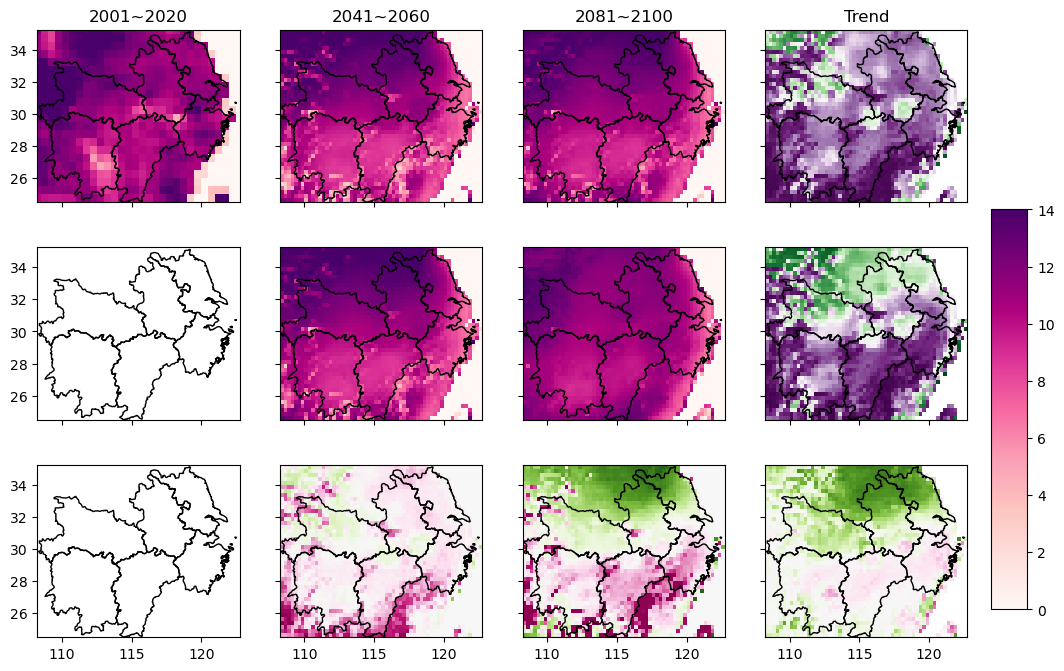

In [30]:
vmax=14
fig, axes = plt.subplots(3, 4, figsize=(12, 8), sharex=True, sharey=True)
gr[0].plot(ax=axes[0][0], cmap='RdPu', add_colorbar=False, add_labels=False, vmin=0, vmax=vmax)
#yrb.boundary.plot(ax=axes[0][0], color='lightgrey', linewidth=0.5)
#gdf.boundary.plot(ax=axes[0][0], color='black', linewidth=1.5)
for i in range(3):
    for j in range(4):
        multi.boundary.plot(ax=axes[i][j], color='black', linewidth=1)
        

axes[0][0].set_title('2001~2020')
axes[0][1].set_title('2041~2060')
axes[0][2].set_title('2081~2100')
axes[0][3].set_title('Trend')

#hmed[0][-50].plot(ax=axes[0][1], cmap='PuRd', add_colorbar=False, add_labels=False, vmin=0, vmax=vmax)
hmed[1][-60:-40].mean('time').plot(ax=axes[0][1], cmap='RdPu', add_colorbar=False, add_labels=False, vmin=0, vmax=vmax)
#hmed[2][-50].plot(ax=axes[2][1], cmap='PuRd', add_colorbar=False, add_labels=False, vmin=0, vmax=vmax)
hmed[3][-60:-40].mean('time').plot(ax=axes[1][1], cmap='RdPu', add_colorbar=False, add_labels=False, vmin=0, vmax=vmax)

#hmed[0][-1].plot(ax=axes[0][2], cmap='PuRd', add_colorbar=False, add_labels=False, vmin=0, vmax=vmax)
hmed[1][-20:].mean('time').plot(ax=axes[0][2], cmap='RdPu', add_colorbar=False, add_labels=False, vmin=0, vmax=vmax)
#hmed[2][-1].plot(ax=axes[2][2], cmap='PuRd', add_colorbar=False, add_labels=False, vmin=0, vmax=vmax)
hmed[3][-20:].mean('time').plot(ax=axes[1][2], cmap='RdPu', add_colorbar=False, add_labels=False, vmin=0, vmax=vmax)

vmax=1
vmin=-1

hcorr[1].plot(ax=axes[0][3], cmap='PRGn_r', add_colorbar=False, add_labels=False, vmin=vmin, vmax=vmax)
hcorr[3].plot(ax=axes[1][3], cmap='PRGn_r', add_colorbar=False, add_labels=False, vmin=vmin, vmax=vmax)

(hcorr[3]-hcorr[1]).plot(ax=axes[2][3], cmap='PiYG_r', add_colorbar=False, add_labels=False, vmin=vmin, vmax=vmax)

vmax=2
vmin=-2

(hmed[3][-60:-40].mean('time')-hmed[1][-60:-40].mean('time')).plot(ax=axes[2][1], cmap='PiYG_r', add_colorbar=False, add_labels=False, vmin=vmin, vmax=vmax)
(hmed[3][-20:].mean('time')-hmed[1][-20:].mean('time')).plot(ax=axes[2][2], cmap='PiYG_r', add_colorbar=False, add_labels=False, vmin=vmin, vmax=vmax)

cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.5])  # Adjust these values as needed [left, bottom, width, height]

# Draw the colorbar
sm = plt.cm.ScalarMappable(cmap="RdPu", norm=plt.Normalize(0, 14))
fig.colorbar(sm, cax=cbar_ax)

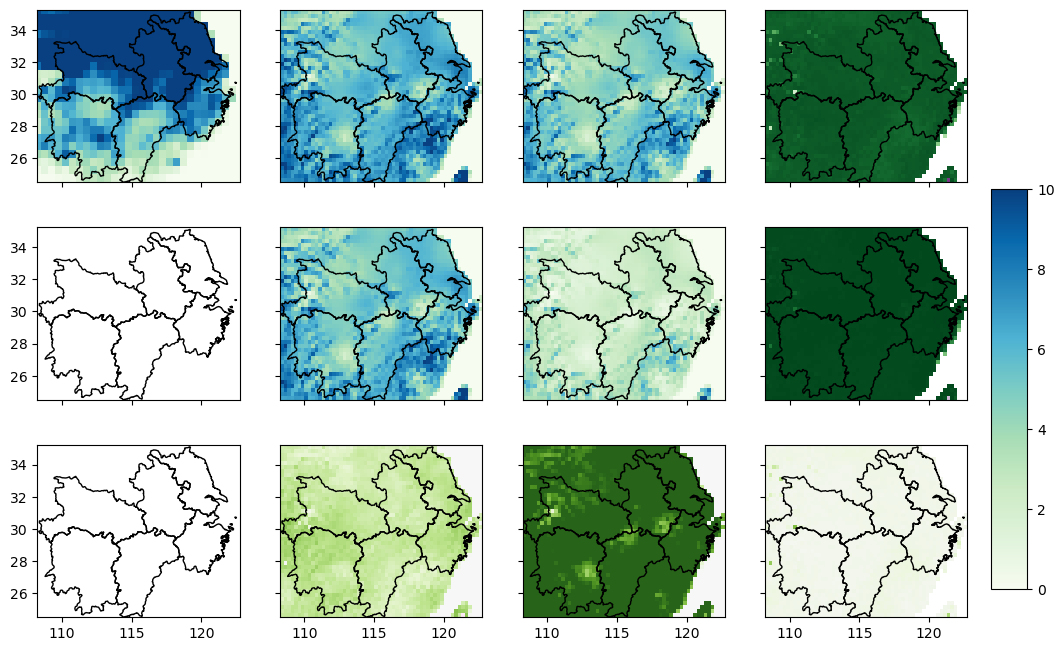

In [42]:
vmax=10

fig, axes = plt.subplots(3, 4, figsize=(12, 8), sharex=True, sharey=True)

for i in range(3):
    for j in range(4):
        multi.boundary.plot(ax=axes[i][j], color='black', linewidth=1)

gr[1].plot(ax=axes[0][0], cmap='GnBu', add_colorbar=False, add_labels=False, vmin=0, vmax=vmax)
#hmed[0][-1].plot(ax=axes[0][2], cmap='OrRd', add_colorbar=False, add_labels=False, vmin=0, vmax=vmax)
cmed[1][-60:-40].mean('time').plot(ax=axes[0][1], cmap='GnBu', add_colorbar=False, add_labels=False, vmin=0, vmax=vmax)
#hmed[2][-1].plot(ax=axes[2][2], cmap='PuRd', add_colorbar=False, add_labels=False, vmin=0, vmax=vmax)
cmed[3][-60:-40].mean('time').plot(ax=axes[1][1], cmap='GnBu', add_colorbar=False, add_labels=False, vmin=0, vmax=vmax)

#hmed[0][-50].plot(ax=axes[0][1], cmap='PuRd', add_colorbar=False, add_labels=False, vmin=0, vmax=vmax)
cmed[1][-20:].mean('time').plot(ax=axes[0][2], cmap='GnBu', add_colorbar=False, add_labels=False, vmin=0, vmax=vmax)
#hmed[2][-50].plot(ax=axes[2][1], cmap='PuRd', add_colorbar=False, add_labels=False, vmin=0, vmax=vmax)
cmed[3][-20:].mean('time').plot(ax=axes[1][2], cmap='GnBu', add_colorbar=False, add_labels=False, vmin=0, vmax=vmax)

vmax=1
vmin=-1

ccorr[1].plot(ax=axes[0][3], cmap='PRGn_r', add_colorbar=False, add_labels=False, vmin=vmin, vmax=vmax)
ccorr[3].plot(ax=axes[1][3], cmap='PRGn_r', add_colorbar=False, add_labels=False, vmin=vmin, vmax=vmax)

(ccorr[3]-ccorr[1]).plot(ax=axes[2][3], cmap='PiYG_r', add_colorbar=False, add_labels=False, vmin=vmin, vmax=vmax)

vmax=2
vmin=-2

(cmed[3][-60:-40].mean('time')-cmed[1][-60:-40].mean('time')).plot(ax=axes[2][1], cmap='PiYG_r', add_colorbar=False, add_labels=False, vmin=vmin, vmax=vmax)
(cmed[3][-20:].mean('time')-cmed[1][-20:].mean('time')).plot(ax=axes[2][2], cmap='PiYG_r', add_colorbar=False, add_labels=False, vmin=vmin, vmax=vmax)
cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.5])  # Adjust these values as needed [left, bottom, width, height]

sm = plt.cm.ScalarMappable(cmap="GnBu", norm=plt.Normalize(0, 10))
fig.colorbar(sm, cax=cbar_ax)

In [ ]:
hmed[1][-60:-40].mean('time')

In [ ]:
gr[0]

# Pred Plot

In [ ]:
models=[f.name for f in os.scandir('output') if f.is_dir()]
pcode_li=['CN032', 'CN033', 'CN034', 'CN036', 'CN042', 'CN043']

In [ ]:
len(models)

In [ ]:
collection={}

pd.read_csv('output/EC-Earth3/results_CN032.csv', usecols=range(1,6))

In [ ]:
def smooth(dfli, n):
        adf=pd.concat([df['pred'] for df in dfli], axis=1)
        
        def calculate_stats(group):
            flattened_group = group.values.flatten()
            max_value = group.to_numpy().max()
            min_value = group.to_numpy().min()
            mean_value = group.mean().mean()  # Calculate mean of means for the group
            percentile_25 = np.percentile(flattened_group, 30)
            percentile_75 = np.percentile(flattened_group, 70)
            return pd.Series({
                'mean': mean_value,
                'max': percentile_75,
                'min': percentile_25,
            })

        # Group the DataFrame into chunks of 'n' and apply the calculate_stats function
        # Ensure the 'year' column is not included in the calculations
        grouped_df = adf.groupby(adf.index // n).apply(calculate_stats)
        grouped_df['YEAR'] = dfli[0]['YEAR'].groupby(adf.index // n).first()  # Retain the year information

        # Resetting index to have a clean DataFrame
        return grouped_df.reset_index(drop=True)

In [ ]:
c1='xkcd:blue green'
c2='xkcd:slate green'
c3='xkcd:puce'
c3e='tan'
c4='xkcd:terracotta'

for i in range(6):
    dfli126=[collection[i].ssp126, collection[i+6].ssp126, collection[i+6+6].ssp126]
    dfli245=[collection[i].ssp245, collection[i+6].ssp245, collection[i+6+6].ssp245]
    dfli370=[collection[i].ssp370, collection[i+6].ssp370, collection[i+6+6].ssp370]
    dfli585=[collection[i].ssp585, collection[i+6].ssp585, collection[i+6+6].ssp585]

    n=10

    e1_p=smooth(dfli126, n)
    e2_p=smooth(dfli245, n)
    e3_p=smooth(dfli370, n)
    e5_p=smooth(dfli585, n)
    
    fig = plt.figure(figsize=(12,7))

    a=sns.lineplot(data=e1_p, x='YEAR', y='mean', label='ssp126', color=c1)
    b=sns.lineplot(data=e2_p, x='YEAR', y='mean', label='ssp245', color=c2)
    c=sns.lineplot(data=e3_p, x='YEAR', y='mean', label='ssp370', color=c3)
    d=sns.lineplot(data=e5_p, x='YEAR', y='mean', label='ssp585', color=c4)
    e=plt.fill_between(e1_p['YEAR'], e1_p['min'], e1_p['max'], alpha=0.3, color=c1)
    f=plt.fill_between(e2_p['YEAR'], e2_p['min'], e2_p['max'], alpha=0.3, color=c2)
    g=plt.fill_between(e3_p['YEAR'], e3_p['min'], e3_p['max'], alpha=0.3, color=c3e)
    h=plt.fill_between(e5_p['YEAR'], e5_p['min'], e5_p['max'], alpha=0.3, color=c4)

    fig.show()

# Taylor

In [9]:
import netCDF4 as nc

In [10]:
def historical(model, datavarname, tvarname, cutoff):

    if datavarname=='pr': 
        if len(glob.glob(f'NASA-CMIP/CMIP6-Historical-PR/pr_day_{model}_*.nc'))>1:         
            data=xr.open_mfdataset(f'NASA-CMIP/CMIP6-Historical-PR/{datavarname}_day_{model}_*.nc')

        else:
            data=xr.open_dataset(f'NASA-CMIP/CMIP6-Historical-PR/{datavarname}_{model}_1979-2014.nc')
    else:

        data=xr.open_mfdataset(f'NASA-CMIP/CMIP6-Historical-Temp/{model}/{datavarname}_day_*.nc')
    new_data=rectangle_clip(multi, data[datavarname])
    # Assuming ds is your xarray dataset
    # Group by year
    grouped = new_data.groupby(f'{tvarname}.year')

    # Pre-allocate a numpy array to store the results
    years = [year for year in grouped.groups if cutoff is None or year >= cutoff]
    nyear = len(grouped.groups)
    nmonth = 12
    lat_dim = len(new_data['lat'])
    lon_dim = len(new_data['lon'])

    result_array = np.empty((0, nmonth, lat_dim, lon_dim))

    # Iterate through each group and fill the result_array
    for i, (year, group) in enumerate(grouped):
        if cutoff is None:
            run=True
        else: 
            if year>=cutoff:
                run=True
                print(year)
            else:
                run=False
        
        if run:
            # Aggregate monthly data for each year
            if datavarname == 'pr':
                monthly_data = group.groupby(f'{tvarname}.month').sum()
            else:
                monthly_data = group.groupby(f'{tvarname}.month').mean()
            result_array=np.concatenate((result_array, monthly_data.values[np.newaxis, :, :, :]), axis=0)
    # Coordinates
    lat = new_data['lat'].values
    lon = new_data['lon'].values
    months = np.arange(1, nmonth + 1)

    if datavarname == 'pr':
        result_array=result_array*86400

    # Wrap in xarray.DataArray
    result_da = xr.DataArray(result_array, coords=[years, months, lat, lon], dims=['year', 'month', 'lat', 'lon'])

    return result_da

In [11]:
def obs(data, datavarname, tvarname, cutoff):
    new_data=rectangle_clip(multi, data[datavarname])
    # Assuming ds is your xarray dataset
    # Group by year
    grouped = new_data.groupby(f'{tvarname}.year')

    # Pre-allocate a numpy array to store the results
    years = [year for year in grouped.groups if cutoff is None or year <= cutoff]
    nyear = len(grouped.groups)
    nmonth = 12
    lat_dim = len(new_data['lat'])
    lon_dim = len(new_data['lon'])

    result_array = np.empty((0, nmonth, lat_dim, lon_dim))

    # Iterate through each group and fill the result_array
    for i, (year, group) in enumerate(grouped):
        if cutoff is None:
            run=True
        else: 
            if year<=cutoff:
                run=True
                print(year)
            else:
                run=False
        
        if run:
            # Aggregate monthly data for each year
            if datavarname == 'pr':
                monthly_data = group.groupby(f'{tvarname}.month').sum()
            else:
                monthly_data = group.groupby(f'{tvarname}.month').mean()
            result_array=np.concatenate((result_array, monthly_data.values[np.newaxis, :, :, :]), axis=0)
    # Coordinates
    lat = new_data['lat'].values
    lon = new_data['lon'].values
    months = np.arange(1, nmonth + 1)

    # Wrap in xarray.DataArray
    result_da = xr.DataArray(result_array, coords=[years, months, lat, lon], dims=['year', 'month', 'lat', 'lon'])

    return result_da

In [12]:
cpc={}

In [ ]:
cpc['tas']=obs(xr.open_dataset(f'Observed_data/tas/air.mon.mean.nc'), 'air', 'time', 2014)

In [13]:
cpc['pr']=obs(xr.open_mfdataset(f'Observed_data/precip/*.nc'), 'precip', 'time', 2014)

1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014


In [14]:
#cpc['tasmax']=obs(xr.open_mfdataset(f'Observed_data/tasmax/*.nc'), 'tmax', 'time', 2014)
cpc['tasmin']=obs(xr.open_mfdataset(f'Observed_data/tasmin/*.nc'), 'tmin', 'time', 2014)

1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014


In [16]:
import concurrent.futures

In [21]:
tas_hist={}

def load_model_data(model):
    return model, historical(model, 'tas', 'time', cutoff=1980)

# Using a process pool to execute tasks concurrently
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Create a future object for each model
    futures = {executor.submit(load_model_data, model): model for model in models}

    for future in concurrent.futures.as_completed(futures):
        model = futures[future]
        try:
            model, result = future.result()
            tas_hist[model] = result
        except Exception as exc:
            print(f'{model} generated an exception: {exc}')

print("Task Completed.")

1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1981
1981
1980
1981
1981
1981
1980
1980
1980
1981
1980
1981
1981
1980
1980
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1982
1982
1981
1982
1982
1982
1982
1981
1981
1982
1981
1981
1982
1981
1981
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1983
1983
1983
1982
1983
1983
1982
1982
1983
1982
1983
1982
1983
1982
1982
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1984
1984
1984
1984
1983
1984
1983
1983
1984
1983
1984
1983
1984
1983
1983
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1985
1985
1984
1985
1985
1985
1984
1984
1985
1984
1985
1984
1984
1985
1984
1985
1985
1985
1985
1985
1985
1985
1985
1985
1986
1985
1985
1986
1986
1986
1985
1986
1985
1986
1985
1986
1985
1985
1986
1985
1986
1986
1986
1986
1986
1986
1986
1986
1987
1986
1987
1986
1986
1986
1987
1987
1987
1986
1987
1987
1986
1986
1987
1986
1987
1986
1987
1987
1987
1987
1987
1987
1987
1988
1988
1987
1987
1988
1987
1987
1988
1988


In [ ]:
tasmax_hist={}

def load_model_data(model):
    return model, historical(model, 'tasmax', 'time', cutoff=1980)

# Using a process pool to execute tasks concurrently
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Create a future object for each model
    futures = {executor.submit(load_model_data, model): model for model in models}

    for future in concurrent.futures.as_completed(futures):
        model = futures[future]
        try:
            model, result = future.result()
            tas_hist[model] = result
        except Exception as exc:
            print(f'{model} generated an exception: {exc}')

print("Task Completed.")

1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1981
1980
1981
1981
1981
1981
1980
1981
1980
1980
1981
1980
1980
1981
1981
1980
1981
1981
1981
1981
1981
1981
1982
1980
1981
1980
1981
1982
1982
1982
1982
1981
1982
1981
1981
1982
1981
1981
1981
1982
1982
1982
1982
1982
1982
1983
1982
1982
1981
1981
1982
1982
1983
1983
1983
1983
1982
1983
1982
1982
1983
1982
1982
1982
1983
1983
1983
1983
1983
1983
1984
1982
1983
1983
1982
1983
1983
1984
1984
1984
1984
1983
1984
1983
1983
1983
1983
1984
1983
1984
1984
1984
1984


In [23]:
tasmin_hist={}

def load_model_data(model):
    return model, historical(model, 'tasmin', 'time', cutoff=1981)

# Using a process pool to execute tasks concurrently
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Create a future object for each model
    futures = {executor.submit(load_model_data, model): model for model in ['HadGEM3-GC31-MM']}

    for future in concurrent.futures.as_completed(futures):
        model = futures[future]
        try:
            model, result = future.result()
            tasmin_hist[model] = result
        except Exception as exc:
            print(f'{model} generated an exception: {exc}')

print("Task Completed.")

1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
Task Completed.


In [26]:
pr_hist={}

def load_model_data(model):
    return model, historical(model, 'pr', 'time', cutoff=1980)

# Using a process pool to execute tasks concurrently
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Create a future object for each model
    futures = {executor.submit(load_model_data, model): model for model in models}

    for future in concurrent.futures.as_completed(futures):
        try:
            model, result = future.result()
            pr_hist[model] = result
        except Exception as exc:
            raise RuntimeError(f'Error at {model}.')

print("Task Completed.")

1980
1980
1980
1980
1980
1980
1980
1980
1980
19801980

1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1980
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1981
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1982
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1983
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988


In [21]:
import csv

def corr_std(data_ref, data_models_dict,varname, dim_lat='lat', dim_lon='lon', save=True):
    if not isinstance(data_ref, xr.DataArray) or not all(isinstance(d, xr.DataArray) for d in data_models_dict.values()):
        raise ValueError("data_ref must be an xArray DataArray and data_models_dict must be a dictionary of xArray DataArrays.")

    # Stack 'year' and 'month' dimensions into 'time_combined'
    data_ref_stacked = data_ref.stack(time_combined=('year', 'month'))

    # Reduce the reference data to 1D by taking the mean over two dimensions
    data_ref_1d = data_ref_stacked.mean(dim=(dim_lat, dim_lon))

    # Calculate standard deviation for the reference dataset
    std_ref = data_ref_stacked.std().values

    results = []

    # Calculate and store correlation and standard deviation for each model
    for model_name, data in data_models_dict.items():
        data_stacked = data.stack(time_combined=('year', 'month'))
        data_1d = data_stacked.mean(dim=(dim_lat, dim_lon))
        std_dev = data_stacked.std().values
        corr = np.corrcoef(data_ref_1d, data_1d)[0, 1]

        results.append({'Model': model_name, 'Correlation': corr, 'Standard Deviation': std_dev})

    if not save:
        return results

    # Save results to a CSV file
    with open(f'{varname}_correlation_std.csv', 'w', newline='') as csvfile:
        fieldnames = ['Model', 'Correlation', 'Standard Deviation']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        writer.writeheader()
        for result in results:
            writer.writerow(result)

    print(f"Results saved to {varname}_correlation_std.csv")

In [82]:
corr_std(cpc['tas'].sel(year=slice(1980, 2014)), tas_hist, 'tas')

NameError: name 'tas_hist' is not defined

In [183]:
corr_std(cpc['tasmax'].sel(year=slice(1980, 2014)), tasmax_hist, 'tasmax')

Results saved to tasmax_correlation_std.csv


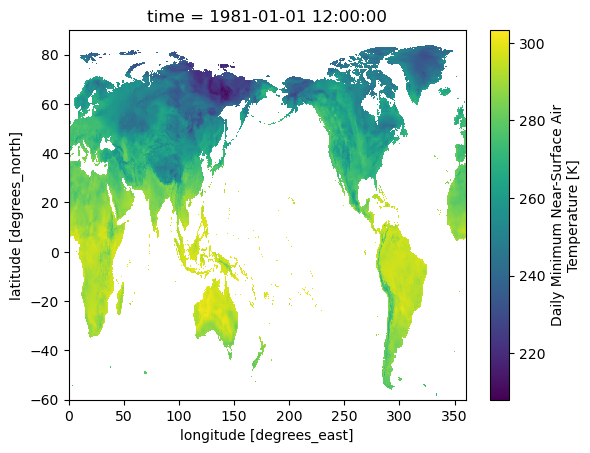

In [99]:
xr.open_dataset('NASA-CMIP/CMIP6-Historical-Temp/HadGEM3-GC31-MM/tasmin_day_HadGEM3-GC31-MM_historical_r1i1p1f3_gn_1981.nc')['tasmin'][0,:,:].plot()

In [24]:
corr_std(cpc['tasmin'].sel(year=slice(1981, 2014)), tasmin_hist, 'tasmin', save=False)

[{'Model': 'HadGEM3-GC31-MM',
  'Correlation': 0.9805981597361842,
  'Standard Deviation': array(8.50977816)}]

In [77]:
corr_std(cpc['pr'].sel(year=slice(1980, 2014)), pr_hist, 'pr')

Results saved to pr_correlation_std.csv


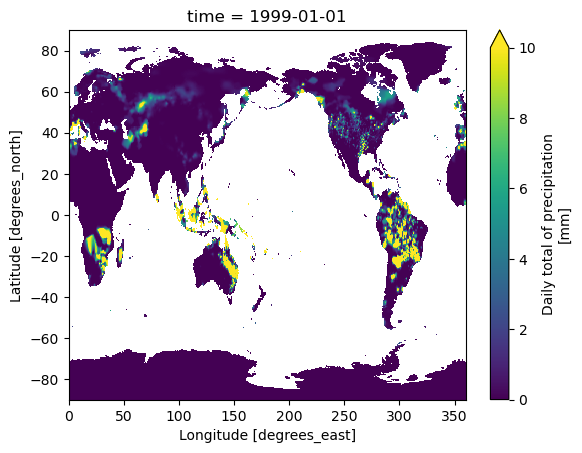

In [120]:
xr.open_dataset('Observed_Data/precip/precip.1999.nc')['precip'][0].plot(vmax=10)

In [26]:
cpc['pr']

<xarray.DataArray (year: 35, month: 12, lat: 22, lon: 30)>
array([[[[1.93233460e-01, 2.14321807e-01, 2.55183578e-01, ...,
                     nan,            nan,            nan],
         [2.76498437e-01, 2.86715657e-01, 3.36882442e-01, ...,
                     nan,            nan,            nan],
         [3.47527891e-01, 3.66530865e-01, 4.22079653e-01, ...,
                     nan,            nan,            nan],
         ...,
         [1.41011608e+00, 1.77669871e+00, 2.37732577e+00, ...,
                     nan,            nan,            nan],
         [1.33506703e+00, 1.93392277e+00, 2.63793349e+00, ...,
          5.26694727e+00,            nan,            nan],
         [1.08120191e+00, 1.61908472e+00, 2.13427830e+00, ...,
          3.95592475e+00,            nan,            nan]],

        [[5.51040322e-02, 6.41660839e-02, 9.63876694e-02, ...,
                     nan,            nan,            nan],
         [4.08971608e-02, 7.02433586e-02, 1.34167373e-01, ...,
                     nan,            nan,            nan],
         [7.52328560e-02, 1.10477455e-01, 1.79141939e-01, ...,
                     nan,            nan,            nan],
...
         [3.32573557e+00, 3.45134449e+00, 3.50545144e+00, ...,
                     nan,            nan,            nan],
         [3.61316562e+00, 4.06800079e+00, 4.09280300e+00, ...,
          5.19280243e+00,            nan,            nan],
         [3.82303715e+00, 3.96524525e+00, 3.91170979e+00, ...,
          7.82031393e+00,            nan,            nan]],

        [[4.44957539e-02, 5.47545329e-02, 6.61394969e-02, ...,
                     nan,            nan,            nan],
         [4.41997759e-02, 5.99748828e-02, 7.82899410e-02, ...,
                     nan,            nan,            nan],
         [3.94197740e-02, 5.53350635e-02, 7.54236206e-02, ...,
                     nan,            nan,            nan],
         ...,
         [3.63840729e-01, 5.10873079e-01, 7.35438824e-01, ...,
                     nan,            nan,            nan],
         [5.10305524e-01, 7.59263575e-01, 9.89713013e-01, ...,
          5.28364563e+00,            nan,            nan],
         [6.89769506e-01, 1.00004303e+00, 1.29785955e+00, ...,
          6.55344200e+00,            nan,            nan]]]])
Coordinates:
  * year     (year) int64 1980 1981 1982 1983 1984 ... 2010 2011 2012 2013 2014
  * month    (month) int32 1 2 3 4 5 6 7 8 9 10 11 12
  * lat      (lat) float32 35.25 34.75 34.25 33.75 ... 26.25 25.75 25.25 24.75
  * lon      (lon) float32 108.2 108.8 109.2 109.8 ... 121.2 121.8 122.2 122.8

In [62]:
cpc['pr'].stack(time_combined=('year', 'month')).mean(dim=('lat', 'lon')).std(dim='time_combined').values

array(1.86339997)

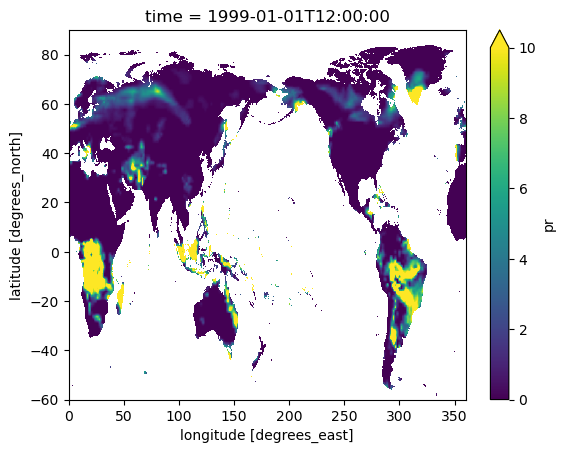

In [119]:
da=xr.open_dataset('NASA-CMIP/CMIP6-Historical-PR/pr_ACCESS-ESM1-5_1979-2014.nc')['pr'][-5844,:,:]*86400
da.plot(vmax=10)

In [44]:
pd.read_csv()

<xarray.DataArray ()>
array(8.50260273)

In [25]:
pd.read_csv('pr_correlation_std.csv')

,Model,Correlation,Standard Deviation
0,ACCESS-CM2,0.757490,80.288858
1,CNRM-CM6-1,0.755711,81.701902
2,FGOALS-g3,0.745465,78.999775
3,CanESM5,0.732031,79.784598
4,ACCESS-ESM1-5,0.769958,84.460563
5,KACE-1-0-G,0.723721,91.883277
6,NorESM2-LM,0.735363,83.546656
7,HadGEM3-GC31-MM,0.751991,79.429289
8,EC-Earth3,0.782271,82.834912
9,IPSL-CM6A-LR,0.785688,78.309601


In [63]:
def plot_taylor_diagram(df, ref_std, ax,var, std_l=8, std_u=10):
    """
    Plots a Taylor diagram from a Pandas DataFrame with adaptive std range.

    Parameters:
    df (DataFrame): A Pandas DataFrame with 'model', 'std', and 'corr' columns.
    ref_std (float): The standard deviation of the reference dataset.
    """

    # Convert correlations to radians
    corrs = df['Correlation'].values
    thetas = -np.arccos(corrs)

    # Determine the max std for setting plot limits
    max_std = max(df['Standard Deviation'].max(), ref_std)

    # Polar plot
    ax.set_theta_zero_location('E')  # Set 0 degrees to the right
    ax.set_theta_direction(-1)  # Clockwise

    # Plot each model
    for index, row in df.iterrows():
        ax.plot(thetas[index], row['Standard Deviation'], 'o', label=row['Model'])

    # Add reference point and grid
    ax.plot(0, ref_std, 'o', label='Reference', color='black')
    ax.set_rmax(std_u)
    ax.set_rmin(std_l)
    ax.grid(True)

    # Add labels
    ticks = np.linspace(0, -np.pi/2, 6)
    ax.set_thetagrids(np.degrees(ticks), labels=['1.', '0.8', '0.6', '0.4', '0.2', '0.'])

    # Add axis titles
    ax.text(np.radians(4), std_u-std_u/20, 'Standard Deviation', rotation=0, ha='center', va='center')
    ax.text(np.radians(-45), std_u*1.02, 'Correlation', rotation=0, ha='center', va='center')
    ax.set_title(f'historical-{var}')

    plt.gca()

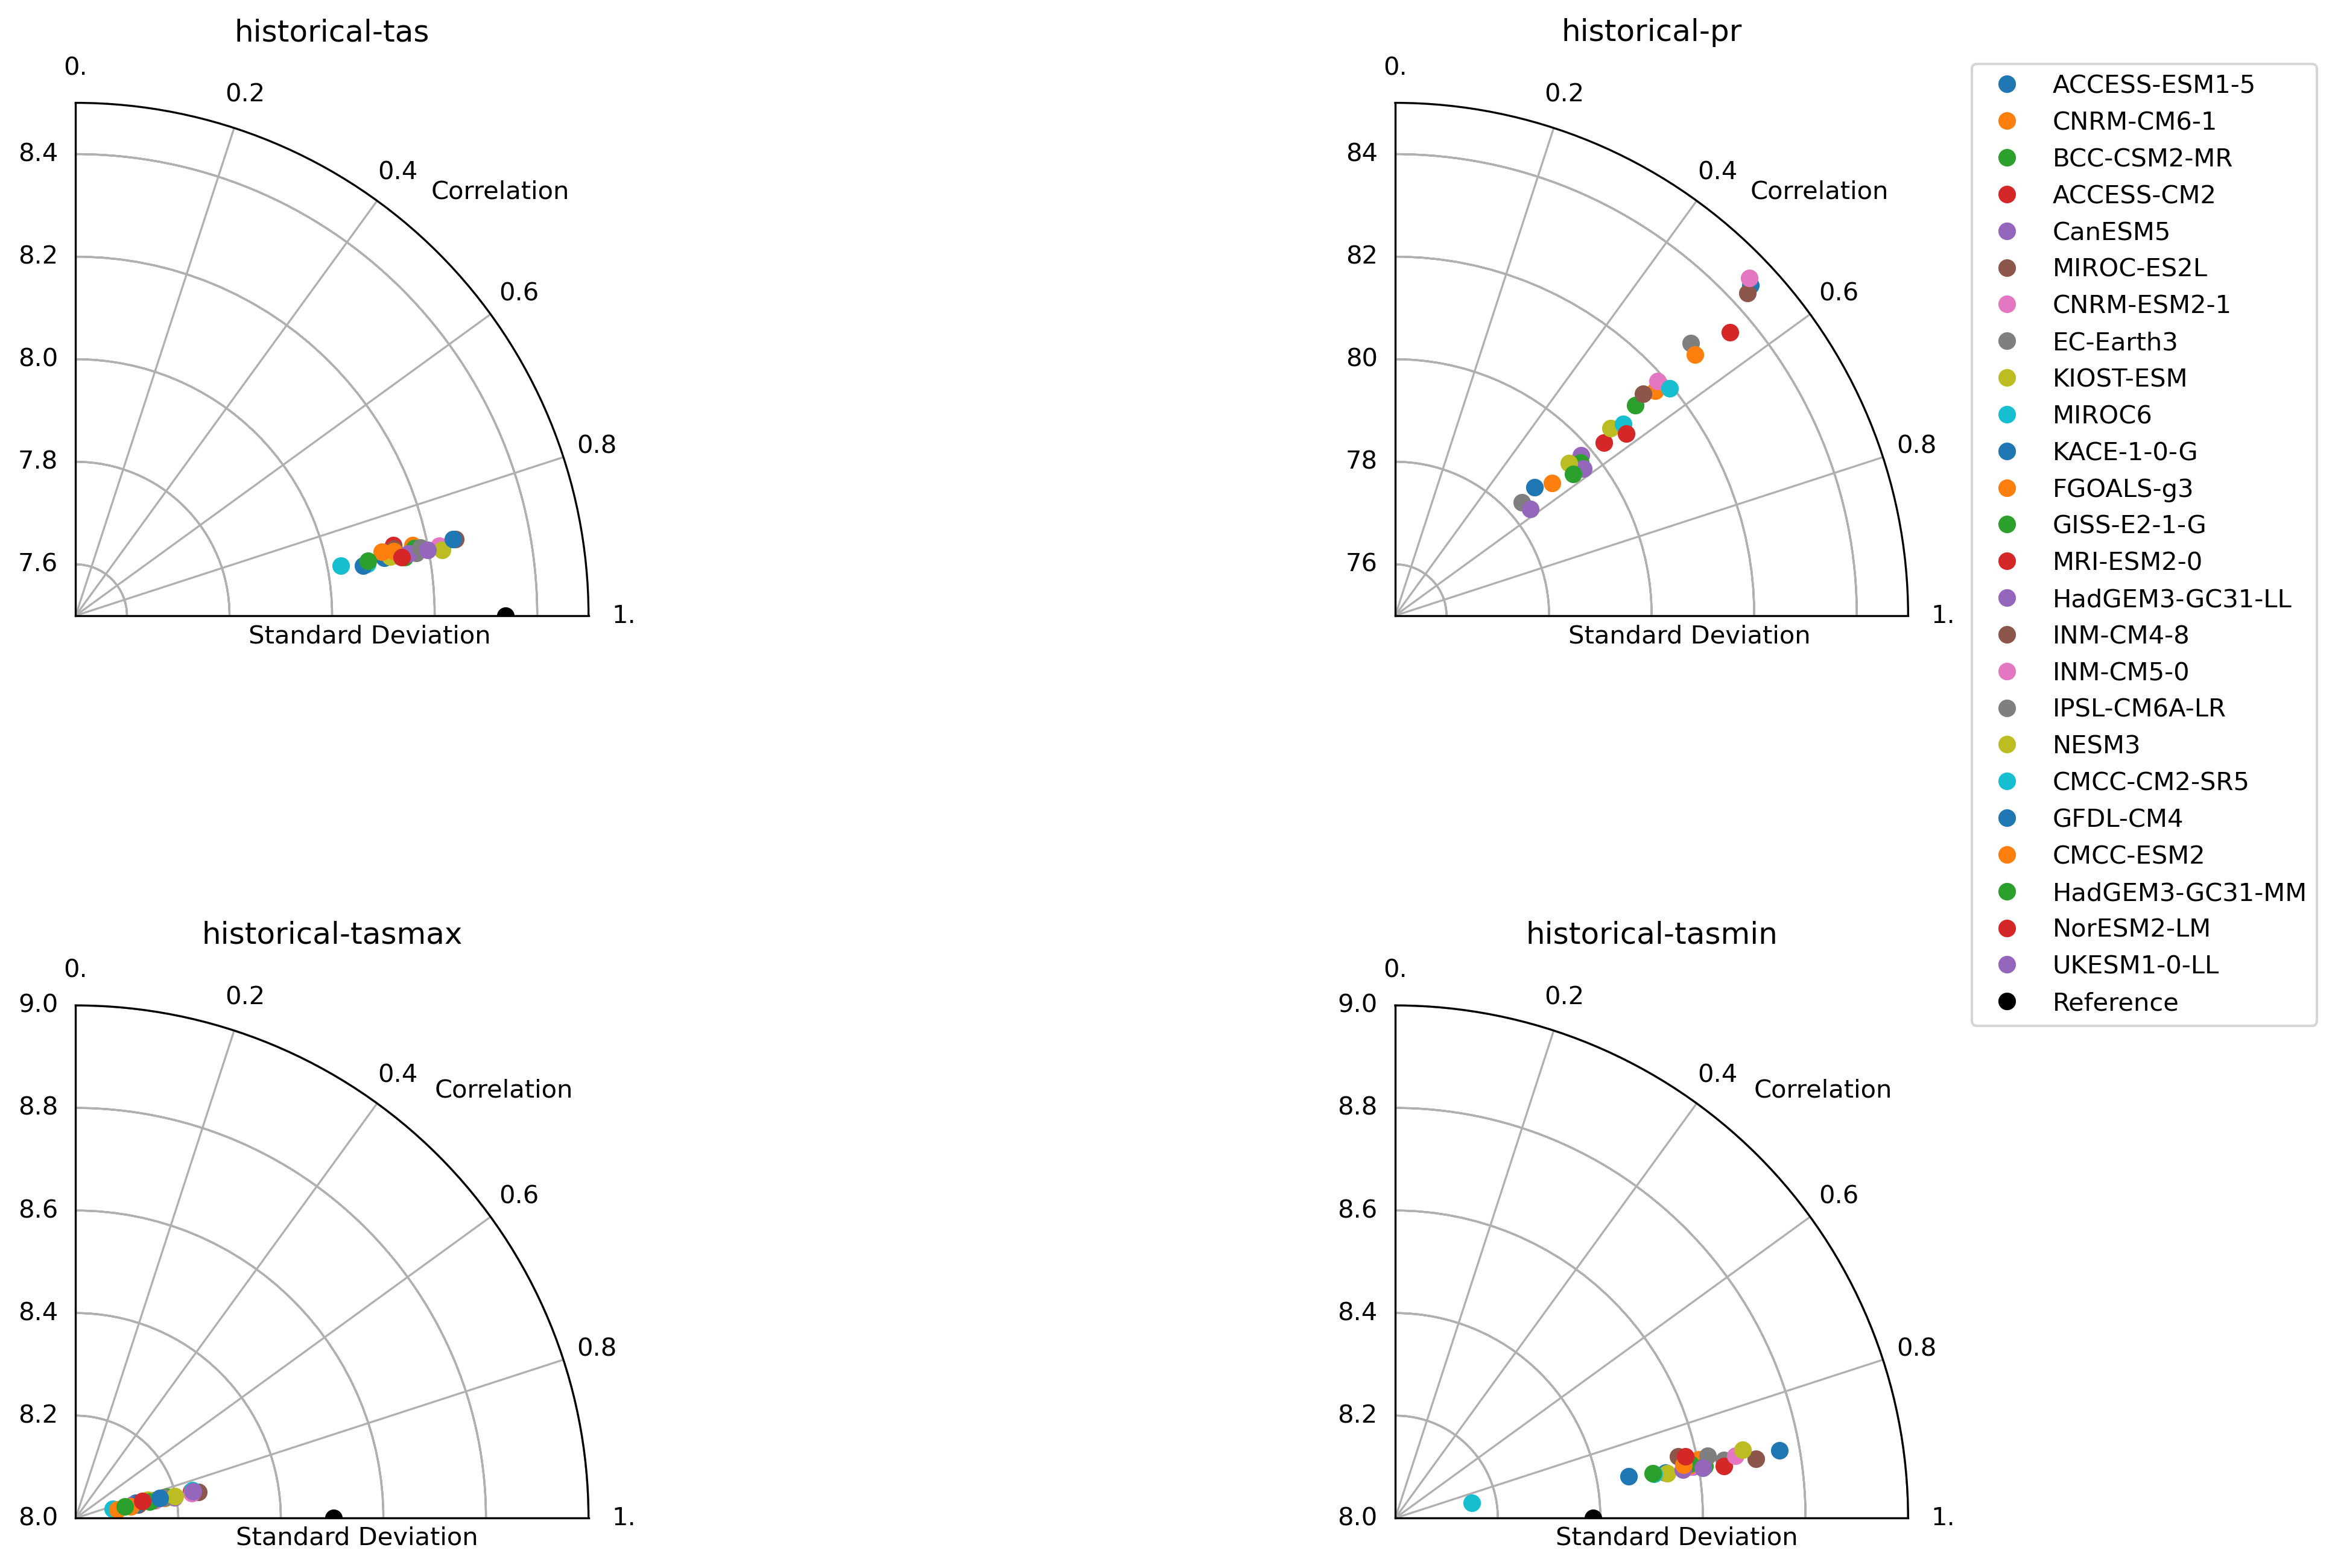

In [64]:
fig, ax = plt.subplots(2, 2, subplot_kw={'projection': 'polar'}, figsize=(18, 10), dpi=300)

df=pd.read_csv('tas_correlation_std.csv')
df['Model'] = pd.Categorical(df['Model'], categories=models, ordered=True)

plot_taylor_diagram(df.sort_values('Model'), 8.33753147, ax[0][0], 'tas', std_l=7.5, std_u=8.5)


df=pd.read_csv('pr_correlation_std.csv')
df['Model'] = pd.Categorical(df['Model'], categories=models, ordered=True)

plot_taylor_diagram(df.sort_values('Model'), 2.87035611, ax[0][1], 'pr', std_l=75, std_u=85)


df=pd.read_csv('tasmax_correlation_std.csv')
df['Model'] = pd.Categorical(df['Model'], categories=models, ordered=True)

plot_taylor_diagram(df.sort_values('Model'), 8.50260273, ax[1][0], 'tasmax', std_u=9)


df=pd.read_csv('tasmin_correlation_std.csv')
df['Model'] = pd.Categorical(df['Model'], categories=models, ordered=True)

plot_taylor_diagram(df.sort_values('Model'), 8.3861444, ax[1][1], 'tasmin', std_u=9)



ax[0][1].legend(loc='upper left', bbox_to_anchor=(1.1, 1.1))

fig.tight_layout()

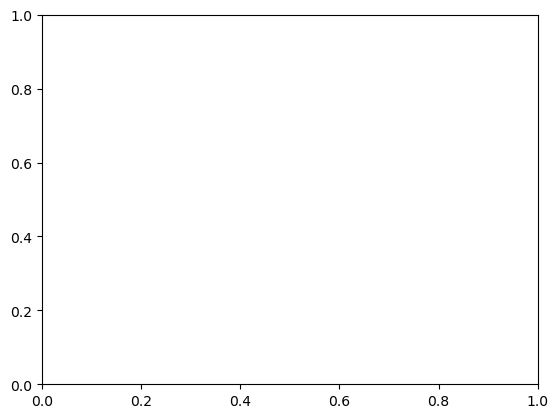

In [188]:
df=pd.read_csv('tasmax_correlation_std.csv')
df['Model'] = pd.Categorical(df['Model'], categories=models, ordered=True)
df.sort_values('Model')

,Model,Correlation,Standard Deviation
22,ACCESS-ESM1-5,0.978738,8.121172
23,CNRM-CM6-1,0.974998,8.178488
8,BCC-CSM2-MR,0.975100,8.181610
21,ACCESS-CM2,0.973929,8.125374
5,CanESM5,0.973102,8.114919
16,MIROC-ES2L,0.972688,8.125017
6,CNRM-ESM2-1,0.976522,8.158948
17,EC-Earth3,0.972449,8.153903
24,KIOST-ESM,0.973645,8.144812
10,MIROC6,0.973621,8.074638
